# Blackhole emission models

Synthesizer can utilise several different black hole emission models, i.e. a model that translates a set of physical properties to one or several spectral energy distributions. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from synthesizer.blackhole_emission_models import Template, UnifiedAGN
from synthesizer.sed import plot_spectra
from unyt import Hz, angstrom, deg, erg, s

### `Template` model

Our simplest model is to just provide a template, either directly (as we'll demonstrate here) or from a file. This is simply scaled by the blackhole bolometric luminosity to produce the spectra.

In [2]:
# Make a fake template
lnu = np.linspace(10, 100, 1000) * erg / Hz / s
lams = np.linspace(10**2, 10**5, 1000) * angstrom

# Define the template model
temp_model = Template(lam=lams, lnu=lnu)

We can then interface this emission model with `particle.BlackHoles` (docs [here](particle_blackholes.ipynb)) or `parametric.Blackhole` (docs [here](parametric_blackholes.ipynb)) objects, or get the spectra scaled by bolometric luminosity directly from the emission model as shown below.

In [3]:
spectra = temp_model.get_spectra(bolometric_luminosity=10**42.0 * erg / s)

### `UnifiedAGN` model

Our default model is the `UnifiedAGN` model. This combines a disc model with a model for the NLR, BLR, and torus.

This model is initialised with a `disc_model`, by default we use the model of Kubota and Done 2019  (https://ui.adsabs.harvard.edu/abs/2018MNRAS.480.1247K/abstract), a photoionisation model string (for demonstration purposes below we won't use one), a filepath to the grid directory containing the NLR and BLR grid files, and any additional fixed parameters.

In [4]:
grid_dir = "../../../tests/test_grid/"
emission_model = UnifiedAGN(
    disc_model="test_grid_agn", photoionisation_model="", grid_dir=grid_dir
)

There are various parameter lists associated with this model which you can access as attributes. 

There's the parameters related to the disc:

In [5]:
emission_model.disc_parameters

['mass', 'accretion_rate_eddington', 'cosine_inclination']

The parameters of the grid(s):

In [6]:
emission_model.grid_parameters

['mass',
 'accretion_rate_eddington',
 'cosine_inclination',
 'metallicity',
 'ionisation_parameter',
 'hydrogen_density']

The parameters of the torus:

In [7]:
emission_model.torus_parameters

['theta_torus', 'torus_emission_model']

And all the parameters of the model:

In [8]:
emission_model.parameters

['metallicity',
 'velocity_dispersion_blr',
 'accretion_rate_eddington',
 'mass',
 'theta_torus',
 'cosine_inclination',
 'ionisation_parameter_blr',
 'velocity_dispersion_nlr',
 'bolometric_luminosity',
 'covering_fraction_blr',
 'hydrogen_density_nlr',
 'covering_fraction_nlr',
 'hydrogen_density_blr',
 'torus_emission_model',
 'ionisation_parameter_nlr']

In addition to the above parameter lists there is also a list of `fixed_parameters` and `variable_parameters`. Fixed parameters are parameters passed at instantiation of an emission model. These will be always take precedence over any parameters passed to spectra methods (e.g. `get_spectra`, see below) or inherited from `BlackHole/s` objects (see the [particle](particle_blackholes.ipynb) and [parametric](parametric_blackholes.ipynb) black hole docs). 

Variable parameters are the opposite of fixed parameters. Any parameter not passed at instantiation is considered "variable" and **will** take any passed or inherited values.

Above we didn't pass any parameters at instansiation of the model, below we will reinstantiate the emission model with some fixed parameters to demonstrate this. Notice too, passing `verbose=True` will result in a report of the defaults used for variable parameters.

In [9]:
emission_model = UnifiedAGN(
    disc_model="test_grid_agn",
    photoionisation_model="",
    grid_dir=grid_dir,
    ionisation_parameter_blr=0.1,
    ionisation_parameter_nlr=0.01,
    covering_fraction_blr=0.1,
    covering_fraction_nlr=0.1,
    verbose=True,
)
print()
print("Fixed:", emission_model.fixed_parameters)
print("Variable:", emission_model.variable_parameters)

Defaults Used:
    hydrogen_density_blr = 1000000000.0 cm**(-3)
    velocity_dispersion_blr = 2000 km/s
    hydrogen_density_nlr = 10000.0 cm**(-3)
    velocity_dispersion_nlr = 500 km/s
    theta_torus = 10 degree
    torus_emission_model = <synthesizer.dust.emission.Greybody object at 0x7f65194108e0>



Fixed: ['ionisation_parameter_blr', 'covering_fraction_blr', 'ionisation_parameter_nlr', 'covering_fraction_nlr']
Variable: ['metallicity', 'accretion_rate_eddington', 'mass', 'theta_torus', 'cosine_inclination', 'velocity_dispersion_nlr', 'bolometric_luminosity', 'hydrogen_density_nlr', 'velocity_dispersion_blr', 'torus_emission_model', 'hydrogen_density_blr']


Some of the variable parameters do not have default values and must either be passed to a method or inherited. These are listed in `required_parameters`.

In [10]:
emission_model.required_parameters

['metallicity',
 'accretion_rate_eddington',
 'mass',
 'cosine_inclination',
 'bolometric_luminosity']

For the `UnifiedAGN` model a handful of spectra are created, a list of all these available spectra is also available as an attribute.

In [11]:
emission_model.available_spectra

['disc_incident_isotropic',
 'disc_incident',
 'disc_escape',
 'disc_transmitted',
 'disc',
 'nlr',
 'blr',
 'torus',
 'intrinsic']

#### Generating spectra

We can generate spectra using the `get_spectra` method and passing the necessary parameters. In this case the blackhole `mass`, the accretion rate expressed as a fraction of the Eddington rate (`accretion_rate_eddington`), the cosine of the inclination (`cosine_inclination`), and the `metallicity`.  Other disc models have different parameters. 

Note that passing parameters which have been fixed will result in a warning saying so.

In [12]:
spectra = emission_model.get_spectra(
    mass=1e9,
    accretion_rate_eddington=1.0,
    cosine_inclination=0.5,
    metallicity=0.01,
    ionisation_parameter_blr=0.1,
    ionisation_parameter_nlr=0.01,
)

Ignoring ionisation_parameter_blr, it was fixed at instantiation.
Ignoring ionisation_parameter_nlr, it was fixed at instantiation.


/opt/hostedtoolcache/Python/3.10.14/x64/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: overflow encountered in exp
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


Note, the combined spectra from the AGN is labelled as "intrinsic". While moderately confusing this is to align with the labelling of stellar population spectra. When associated with a galaxy the "emergent", "dust", and "total" spectra can be generated if diffuse dust attenuation (and emission) is specified.

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='$\\lambda/[\\mathrm{\\AA}]$', ylabel='$L/[\\mathrm{\\rm{erg} / \\rm{s}}]$'>)

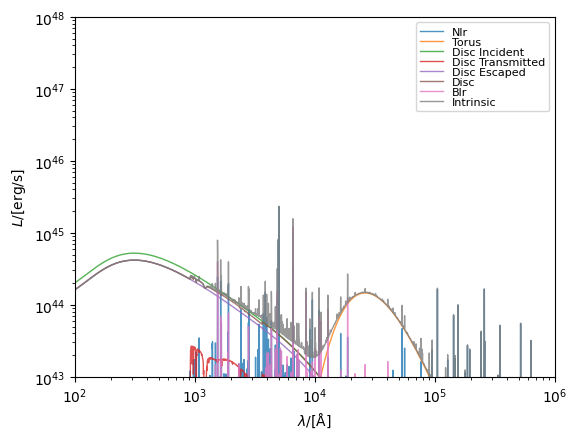

In [13]:
plot_spectra(
    spectra,
    quantity_to_plot="luminosity",
    figsize=(6, 6),
    xlimits=[1e2, 1e6],
    ylimits=[1e43, 1e48],
)

#### Inclination dependence

When the inclination is high ($>90^{\circ}-\theta_{torus}$) the disc and BLR are assumed to be entirely obscured by the dusty torus. In this case the emission from the disc and BLR is set to zero.

In addition some disc models (e.g. AGNSED) have a dependence on the inclination. This effects the emission observed from the disc but not how the NLR, BLR, and torus are illuminated.

/opt/hostedtoolcache/Python/3.10.14/x64/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


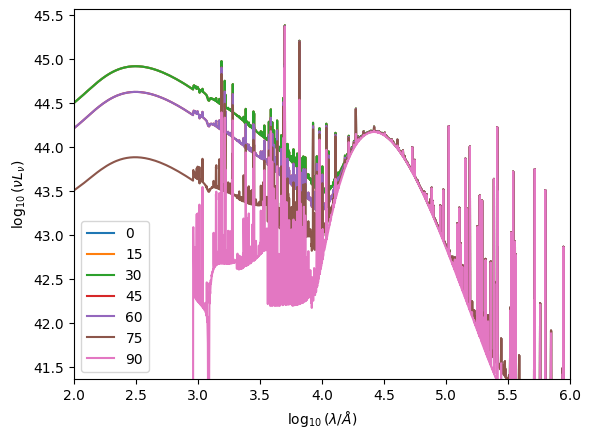

In [14]:
for inclination in [0, 15, 30, 45, 60, 75, 90]:
    cosine_inclination = np.cos((inclination * deg).to_value("rad"))
    spectra = emission_model.get_spectra(
        mass=1e9,
        accretion_rate_eddington=1.0,
        cosine_inclination=cosine_inclination,
        metallicity=0.01,
    )

    sed = spectra["intrinsic"]
    plt.plot(np.log10(sed.lam), np.log10(sed.luminosity), label=inclination)

plt.xlim([2, 6])
plt.ylim(
    np.max(np.log10(sed.luminosity)) - 4,
    np.max(np.log10(sed.luminosity)) + 0.2,
)
plt.xlabel(r"$\log_{10}(\lambda/\AA)$")
plt.ylabel(r"$\log_{10}(\nu L_{\nu})$")
plt.legend()
plt.show()